In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import tqdm

from datasets import CelebaSegmentation, CelebAPosNegDataset
from nn_modules import Image2VectorWithCE

BATCH_SIZE = 4
NUM_WORKERS = 4
DATA_PATH = Path('/root/dmartynov/celeba/celeba')
WIDTH, HEIGHT = 178, 218
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Data

In [3]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Pad(((256 - WIDTH) // 2, (256 - HEIGHT) // 2)),
    #transforms.Resize((256, 256)),
    transforms.ToTensor()
])

## Train

In [4]:
train_dataset = CelebAPosNegDataset(
    data_path=DATA_PATH,
    class_name='Bald',
    transform=transform,
    n_pairs=100,
    pos_left_border=0,
    pos_right_border=50,
    neg_left_border=0,
    neg_right_border=200,
)
train_dataloader = data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)

## Test

In [10]:
test_dataset = CelebAPosNegDataset(
    data_path=DATA_PATH,
    class_name='Bald',
    transform=transform,
    n_pairs=500,
    pos_left_border=1000,
    pos_right_border=2000,
    neg_left_border=1000,
    neg_right_border=2000,
)
test_dataloader = data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)

## More data

In [4]:
train_dataset = CelebAPosNegDataset(
    data_path=DATA_PATH,
    class_name='Bald',
    transform=transform,
    n_pairs=400,
    pos_left_border=0,
    pos_right_border=200,
    neg_left_border=0,
    neg_right_border=800,
)
train_dataloader = data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)
test_dataset = CelebAPosNegDataset(
    data_path=DATA_PATH,
    class_name='Bald',
    transform=transform,
    n_pairs=800,
    pos_left_border=1000,
    pos_right_border=2000,
    neg_left_border=1000,
    neg_right_border=3000,
)
test_dataloader = data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)

# Pairwise only

## Model, optimizer, criterion

In [5]:
model = Image2VectorWithCE(num_out=1).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=3e-4)
pairwise_criterion = nn.MarginRankingLoss()

## Train

In [6]:
n_epochs = 10

accuracy_on_epochs = list()
precision_on_epochs = list()
recall_on_epochs = list()
train_pairwise_losses_on_epochs = list()
test_pairwise_losses_on_epochs = list()

for epoch_num in range(n_epochs):
    print(f'\nEPOCH {epoch_num}')
    pairwise_losses = list()
    test_pairwise_losses = list()
    train_true_pos = 0
    train_true_neg = 0
    train_false_pos = 0
    train_false_neg = 0

    test_true_pos = 0
    test_true_neg = 0
    test_false_pos = 0
    test_false_neg = 0

    for i, batch in enumerate(tqdm.tqdm(train_dataloader)):
        optimizer.zero_grad()

        positive_images, negative_images, labels, _ = batch
        positive_images = positive_images.to(DEVICE)
        negative_images = negative_images.to(DEVICE)
        labels = labels.to(DEVICE)

        positive_outputs = model(positive_images).squeeze(1)
        negative_outputs = model(negative_images).squeeze(1)
        positive_probs = torch.sigmoid(positive_outputs)
        negative_probs = torch.sigmoid(negative_outputs)
            
        train_true_pos += (positive_probs > 0.5).sum().item()
        train_false_neg += (positive_probs < 0.5).sum().item()
        train_true_neg += (negative_probs < 0.5).sum().item()
        train_false_pos += (negative_probs > 0.5).sum().item()

        pairwise_loss = -(positive_probs - negative_probs).mean()
        #pairwise_loss = pairwise_criterion(positive_probs, negative_probs, labels)
        pairwise_losses.append(pairwise_loss.item())

        pairwise_loss.backward()
        optimizer.step()

    print(positive_probs)
    print(negative_probs)

    with torch.no_grad():
        for i, batch in enumerate(tqdm.tqdm(test_dataloader)):
            positive_images, negative_images, labels, _ = batch
            positive_images = positive_images.to(DEVICE)
            negative_images = negative_images.to(DEVICE)
            labels = labels.to(DEVICE)

            positive_outputs = model(positive_images).squeeze(1)
            negative_outputs = model(negative_images).squeeze(1)
            positive_probs = torch.sigmoid(positive_outputs)
            negative_probs = torch.sigmoid(negative_outputs)
                
            test_true_pos += (positive_probs > 0.5).sum().item()
            test_false_neg += (positive_probs < 0.5).sum().item()
            test_true_neg += (negative_probs < 0.5).sum().item()
            test_false_pos += (negative_probs > 0.5).sum().item()
            
            #pairwise_loss = pairwise_criterion(positive_probs, negative_probs, labels)
            pairwise_loss = -(positive_probs - negative_probs).mean()
            test_pairwise_losses.append(pairwise_loss.item())
            
    print(positive_probs)
    print(negative_probs)

    accuracy = (test_true_pos + test_true_neg) / (test_true_pos + test_true_neg + test_false_pos + test_false_neg)
    precision = test_true_pos / (test_true_pos + test_false_pos)
    recall = test_true_pos / (test_true_pos + test_false_neg)
    train_mean_pairwise_loss = sum(pairwise_losses) / len(pairwise_losses)
    test_mean_pairwise_loss = sum(test_pairwise_losses) / len(test_pairwise_losses)
    
    accuracy_on_epochs.append(accuracy)
    precision_on_epochs.append(precision)
    recall_on_epochs.append(recall)
    train_pairwise_losses_on_epochs.append(train_mean_pairwise_loss)
    test_pairwise_losses_on_epochs.append(test_mean_pairwise_loss)
    
    print('rates:')
    print(test_true_pos, test_true_neg, test_false_pos, test_false_neg)
    print(f'test accuracy: {accuracy}')
    print(f'precision: {precision}')
    print(f'recall: {recall}')
    print(f'mean pairwise loss, train: {train_mean_pairwise_loss}')
    print(f'mean pairwise loss, test: {test_mean_pairwise_loss}')


EPOCH 0


  0%|                                                                                                                                                                                      | 0/100 [00:00<?, ?it/s]/root/miniconda3/envs/pixemb/lib/python3.7/site-packages/torch/nn/functional.py:1909: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.17it/s]


tensor([0.9954, 0.9418, 0.7064, 0.9119], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
tensor([0.0021, 0.0012, 0.1457, 0.0061], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.15it/s]


tensor([0.9818, 0.9880, 0.9902, 0.8768], device='cuda:0')
tensor([0.0081, 0.0635, 0.3472, 0.4092], device='cuda:0')
rates:
729 699 101 71
test accuracy: 0.8925
precision: 0.8783132530120482
recall: 0.91125
mean pairwise loss, train: -0.37519884794950487
mean pairwise loss, test: -0.6816461741551757

EPOCH 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.16it/s]


tensor([0.9805, 0.9985, 0.9650, 0.9879], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
tensor([0.0029, 0.0037, 0.0071, 0.0002], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.12it/s]


tensor([0.9892, 0.8541, 0.8470, 0.9690], device='cuda:0')
tensor([0.0043, 0.2785, 0.0207, 0.4570], device='cuda:0')
rates:
725 696 104 75
test accuracy: 0.888125
precision: 0.8745476477683957
recall: 0.90625
mean pairwise loss, train: -0.7402984858676791
mean pairwise loss, test: -0.7170337907224894

EPOCH 2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.16it/s]


tensor([0.0110, 0.4154, 0.9728, 0.1470], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
tensor([1.8916e-03, 6.8644e-05, 5.7806e-06, 7.5419e-04], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.13it/s]


tensor([0.8060, 0.0361, 0.9361, 0.5146], device='cuda:0')
tensor([0.0036, 0.0016, 0.0009, 0.0184], device='cuda:0')
rates:
517 765 35 283
test accuracy: 0.80125
precision: 0.9365942028985508
recall: 0.64625
mean pairwise loss, train: -0.766382604688406
mean pairwise loss, test: -0.5535419050976634

EPOCH 3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.16it/s]


tensor([0.9977, 0.9942, 0.9978, 0.9996], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
tensor([7.6359e-01, 7.2427e-02, 2.8039e-04, 8.0831e-04], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.12it/s]


tensor([0.9815, 0.9984, 0.8331, 0.9989], device='cuda:0')
tensor([0.0136, 0.0042, 0.9926, 0.9478], device='cuda:0')
rates:
708 690 110 92
test accuracy: 0.87375
precision: 0.8655256723716381
recall: 0.885
mean pairwise loss, train: -0.7199845384061336
mean pairwise loss, test: -0.7277844635397196

EPOCH 4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.16it/s]


tensor([0.9990, 0.9999, 0.9915, 0.9984], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
tensor([0.7336, 0.1099, 0.0087, 0.9139], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.11it/s]


tensor([0.9998, 0.9995, 0.9628, 0.0531], device='cuda:0')
tensor([8.8545e-01, 2.9453e-04, 4.8579e-03, 4.0130e-03], device='cuda:0')
rates:
762 695 105 38
test accuracy: 0.910625
precision: 0.8788927335640139
recall: 0.9525
mean pairwise loss, train: -0.8365112535655499
mean pairwise loss, test: -0.8066649156808853

EPOCH 5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.16it/s]


tensor([0.9999, 0.9995, 1.0000, 1.0000], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
tensor([0.8804, 0.4757, 0.0978, 0.2337], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.13it/s]


tensor([0.9991, 0.9965, 0.9662, 1.0000], device='cuda:0')
tensor([0.5886, 0.0796, 0.0926, 0.1255], device='cuda:0')
rates:
753 699 101 47
test accuracy: 0.9075
precision: 0.8817330210772834
recall: 0.94125
mean pairwise loss, train: -0.8444769397377968
mean pairwise loss, test: -0.789501270018518

EPOCH 6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.16it/s]


tensor([0.9741, 0.9999, 0.9644, 0.9995], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
tensor([1.2215e-03, 1.6185e-03, 4.1103e-05, 3.2305e-04], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.14it/s]


tensor([0.9999, 0.9997, 1.0000, 0.9999], device='cuda:0')
tensor([3.3317e-05, 3.2265e-03, 6.9480e-04, 5.8356e-07], device='cuda:0')
rates:
712 740 60 88
test accuracy: 0.9075
precision: 0.9222797927461139
recall: 0.89
mean pairwise loss, train: -0.8456648680567741
mean pairwise loss, test: -0.8028485622256994

EPOCH 7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.16it/s]


tensor([0.9923, 0.9997, 1.0000, 0.9944], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
tensor([8.8783e-06, 5.8185e-06, 5.0692e-04, 7.4745e-07], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.12it/s]


tensor([1.0000, 0.9981, 0.8557, 0.9980], device='cuda:0')
tensor([7.1218e-03, 1.3428e-05, 2.5069e-06, 2.4595e-01], device='cuda:0')
rates:
697 757 43 103
test accuracy: 0.90875
precision: 0.9418918918918919
recall: 0.87125
mean pairwise loss, train: -0.9054466870427131
mean pairwise loss, test: -0.8025562360137701

EPOCH 8


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.16it/s]


tensor([1.0000, 1.0000, 1.0000, 1.0000], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
tensor([4.9610e-06, 1.7960e-01, 1.0851e-03, 9.0525e-05], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.11it/s]


tensor([0.9991, 1.0000, 0.9953, 1.0000], device='cuda:0')
tensor([5.5756e-05, 9.0224e-07, 2.1877e-01, 6.6509e-04], device='cuda:0')
rates:
773 723 77 27
test accuracy: 0.935
precision: 0.9094117647058824
recall: 0.96625
mean pairwise loss, train: -0.9215375253558159
mean pairwise loss, test: -0.8509973362088203

EPOCH 9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.16it/s]


tensor([1.0000, 1.0000, 1.0000, 1.0000], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
tensor([3.5993e-03, 2.2443e-03, 1.0539e-06, 2.8363e-08], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.11it/s]

tensor([0.9996, 1.0000, 0.9984, 0.9998], device='cuda:0')
tensor([1.3656e-01, 3.9535e-05, 1.0940e-07, 8.2827e-03], device='cuda:0')
rates:
737 755 45 63
test accuracy: 0.9325
precision: 0.9424552429667519
recall: 0.92125
mean pairwise loss, train: -0.9271412485837937
mean pairwise loss, test: -0.8553250432014465


## Graphs

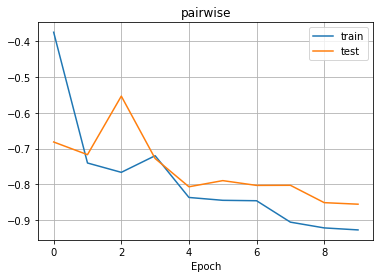

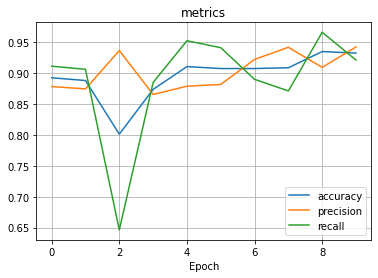

In [7]:
plt.plot(np.arange(0, len(train_pairwise_losses_on_epochs)), train_pairwise_losses_on_epochs, label='train')
plt.plot(np.arange(0, len(test_pairwise_losses_on_epochs)), test_pairwise_losses_on_epochs, label='test')
plt.title('pairwise')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

plt.plot(np.arange(0, len(accuracy_on_epochs)), accuracy_on_epochs, label='accuracy')
plt.plot(np.arange(0, len(precision_on_epochs)), precision_on_epochs, label='precision')
plt.plot(np.arange(0, len(recall_on_epochs)), recall_on_epochs, label='recall')
plt.title('metrics')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

# Pairwise + BCE

## Model, optimizer, criterion

In [9]:
model = Image2VectorWithCE(num_out=1).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=3e-4)
pairwise_criterion = nn.MarginRankingLoss()
bce_criterion = nn.BCELoss()

## Train

EPOCH 0


  0%|                                                                                                                                                                                       | 0/63 [00:00<?, ?it/s]/root/miniconda3/envs/pixemb/lib/python3.7/site-packages/torch/nn/functional.py:1909: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:53<00:00,  1.17it/s]


tensor([0.8351, 0.8802, 0.0116, 0.0714], device='cuda:0',
       grad_fn=<CatBackward0>) tensor([1., 1., 0., 0.], device='cuda:0')


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.07it/s]


tensor([0.4673, 0.6735, 0.0538, 0.3696], device='cuda:0') tensor([1., 1., 0., 0.], device='cuda:0')
rates:
206 217 33 44
accuracy, precision, recall:
0.846 0.8619246861924686 0.824
mean pairwise loss, train: 0.0005418283362237234
mean bce loss, train: 0.3772921253527914
mean pairwise loss, test: 0.017469142105371233
mean bce loss, test: 0.3548787915044361


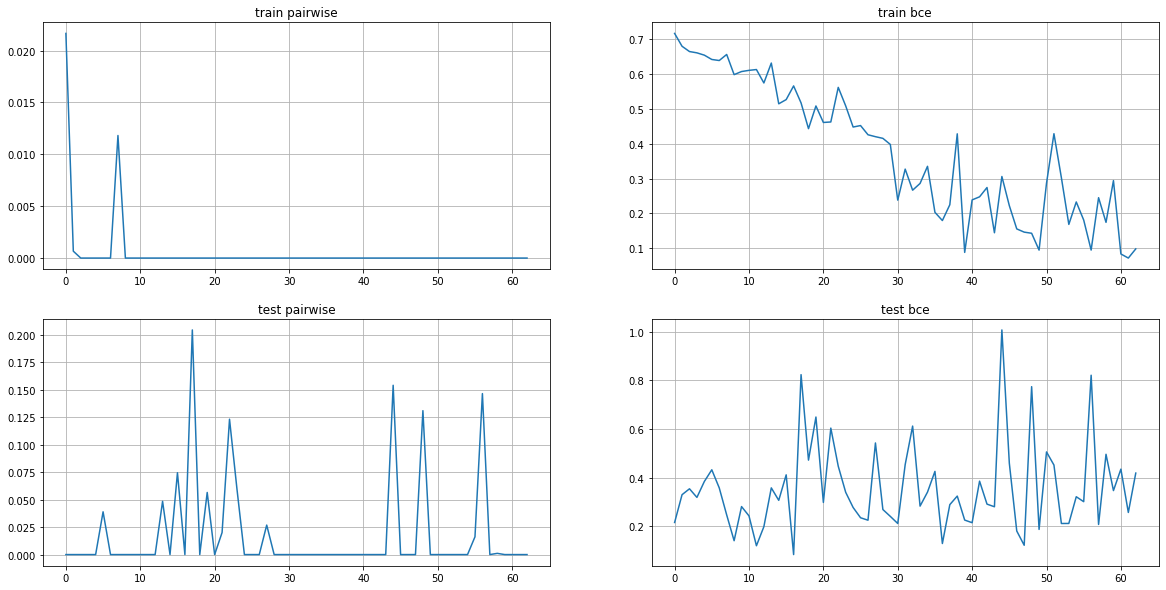

EPOCH 1


  0%|                                                                                                                                                                                       | 0/63 [00:00<?, ?it/s]/root/miniconda3/envs/pixemb/lib/python3.7/site-packages/torch/nn/functional.py:1909: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:54<00:00,  1.17it/s]


tensor([0.9788, 0.9921, 0.0121, 0.0722], device='cuda:0',
       grad_fn=<CatBackward0>) tensor([1., 1., 0., 0.], device='cuda:0')


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.06it/s]


tensor([0.9744, 0.2569, 0.3404, 0.0337], device='cuda:0') tensor([1., 1., 0., 0.], device='cuda:0')
rates:
202 208 42 48
accuracy, precision, recall:
0.82 0.8278688524590164 0.808
mean pairwise loss, train: 0.0022268612233419267
mean bce loss, train: 0.21113391850321067
mean pairwise loss, test: 0.014536046910853613
mean bce loss, test: 0.39250787666865755


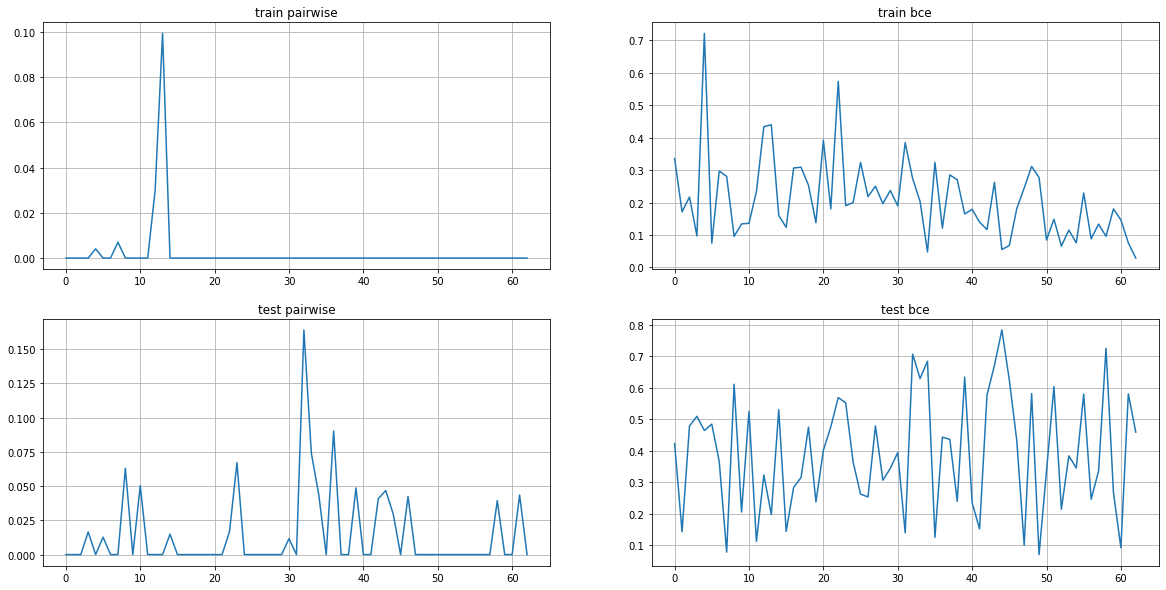

EPOCH 2


  0%|                                                                                                                                                                                       | 0/63 [00:00<?, ?it/s]/root/miniconda3/envs/pixemb/lib/python3.7/site-packages/torch/nn/functional.py:1909: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:54<00:00,  1.17it/s]


tensor([0.8910, 0.7325, 0.1913, 0.0371], device='cuda:0',
       grad_fn=<CatBackward0>) tensor([1., 1., 0., 0.], device='cuda:0')


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.04it/s]


tensor([4.8562e-01, 4.3491e-01, 3.9989e-04, 5.7085e-02], device='cuda:0') tensor([1., 1., 0., 0.], device='cuda:0')
rates:
157 240 10 93
accuracy, precision, recall:
0.794 0.9401197604790419 0.628
mean pairwise loss, train: 0.0009628049437961881
mean bce loss, train: 0.13697713753947663
mean pairwise loss, test: 0.016390380035671923
mean bce loss, test: 0.47844266595821533


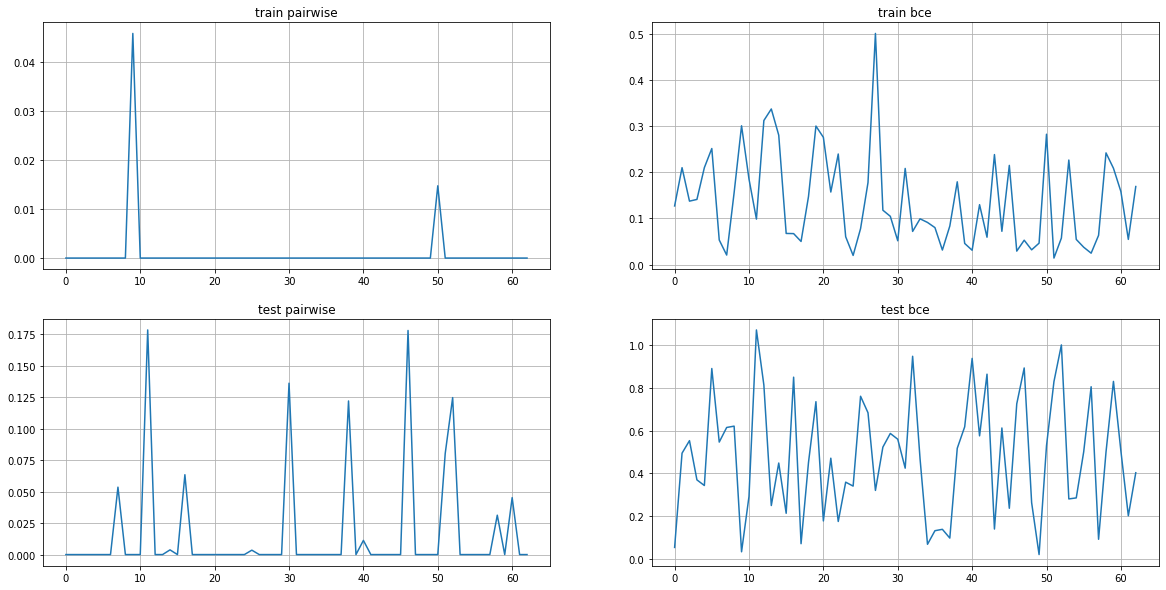

EPOCH 3


  0%|                                                                                                                                                                                       | 0/63 [00:00<?, ?it/s]/root/miniconda3/envs/pixemb/lib/python3.7/site-packages/torch/nn/functional.py:1909: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:54<00:00,  1.17it/s]


tensor([0.9873, 0.9964, 0.0020, 0.0013], device='cuda:0',
       grad_fn=<CatBackward0>) tensor([1., 1., 0., 0.], device='cuda:0')


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.05it/s]


tensor([0.0156, 0.0156, 0.0105, 0.0474], device='cuda:0') tensor([1., 1., 0., 0.], device='cuda:0')
rates:
174 222 28 76
accuracy, precision, recall:
0.792 0.8613861386138614 0.696
mean pairwise loss, train: 0.0
mean bce loss, train: 0.08747675064359865
mean pairwise loss, test: 0.02958079686920558
mean bce loss, test: 0.5316780702994456


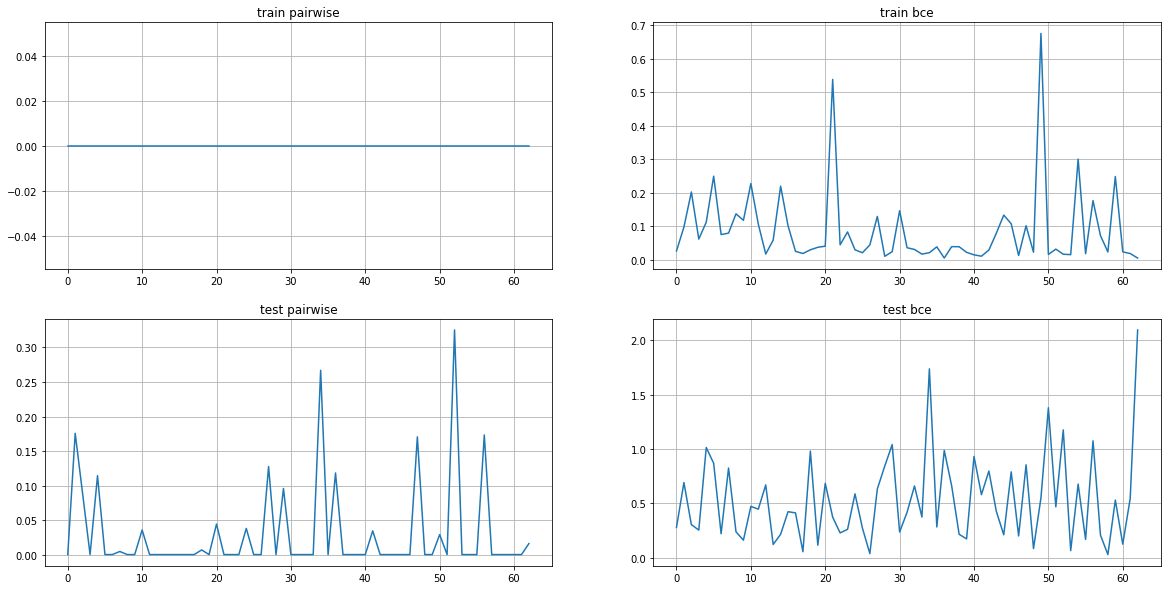

EPOCH 4


  0%|                                                                                                                                                                                       | 0/63 [00:00<?, ?it/s]/root/miniconda3/envs/pixemb/lib/python3.7/site-packages/torch/nn/functional.py:1909: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:54<00:00,  1.17it/s]


tensor([0.9962, 0.9973, 0.0091, 0.0012], device='cuda:0',
       grad_fn=<CatBackward0>) tensor([1., 1., 0., 0.], device='cuda:0')


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.06it/s]


tensor([0.5565, 0.9980, 0.4106, 0.0013], device='cuda:0') tensor([1., 1., 0., 0.], device='cuda:0')
rates:
204 220 30 46
accuracy, precision, recall:
0.848 0.8717948717948718 0.816
mean pairwise loss, train: 0.00162707328323334
mean bce loss, train: 0.08652255058081613
mean pairwise loss, test: 0.01075631155381127
mean bce loss, test: 0.34677962500542875


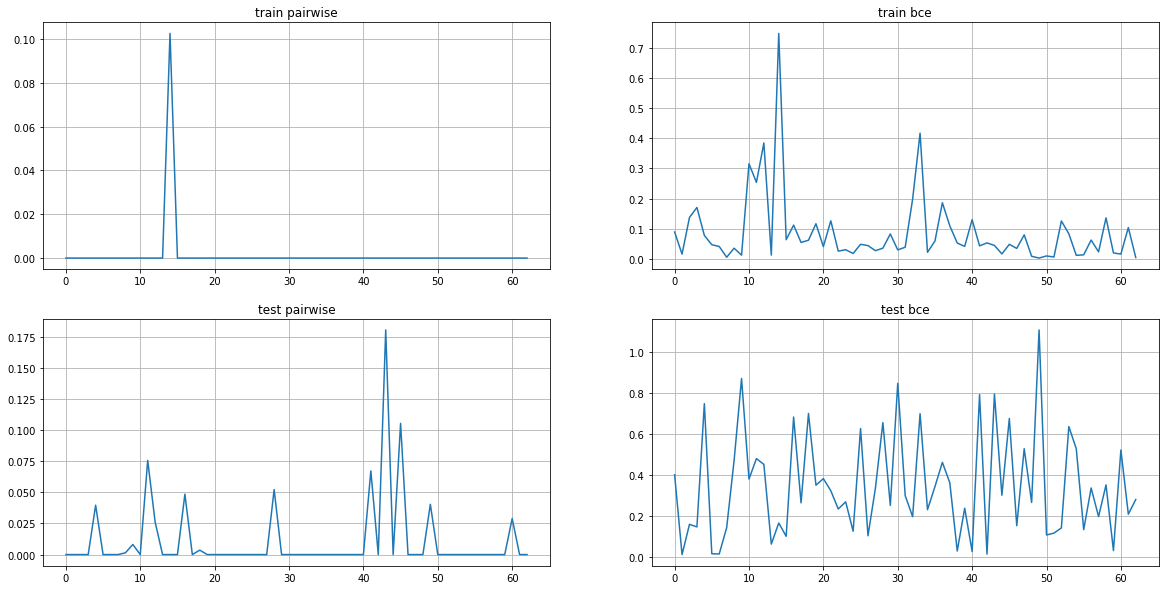

EPOCH 5


  0%|                                                                                                                                                                                       | 0/63 [00:00<?, ?it/s]/root/miniconda3/envs/pixemb/lib/python3.7/site-packages/torch/nn/functional.py:1909: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:53<00:00,  1.17it/s]


tensor([0.9998, 0.6824, 0.0046, 0.0015], device='cuda:0',
       grad_fn=<CatBackward0>) tensor([1., 1., 0., 0.], device='cuda:0')


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.07it/s]


tensor([0.6503, 0.4017, 0.0369, 0.9688], device='cuda:0') tensor([1., 1., 0., 0.], device='cuda:0')
rates:
205 224 26 45
accuracy, precision, recall:
0.858 0.8874458874458875 0.82
mean pairwise loss, train: 0.0
mean bce loss, train: 0.04723590073944439
mean pairwise loss, test: 0.022018143781534737
mean bce loss, test: 0.33763543010822367


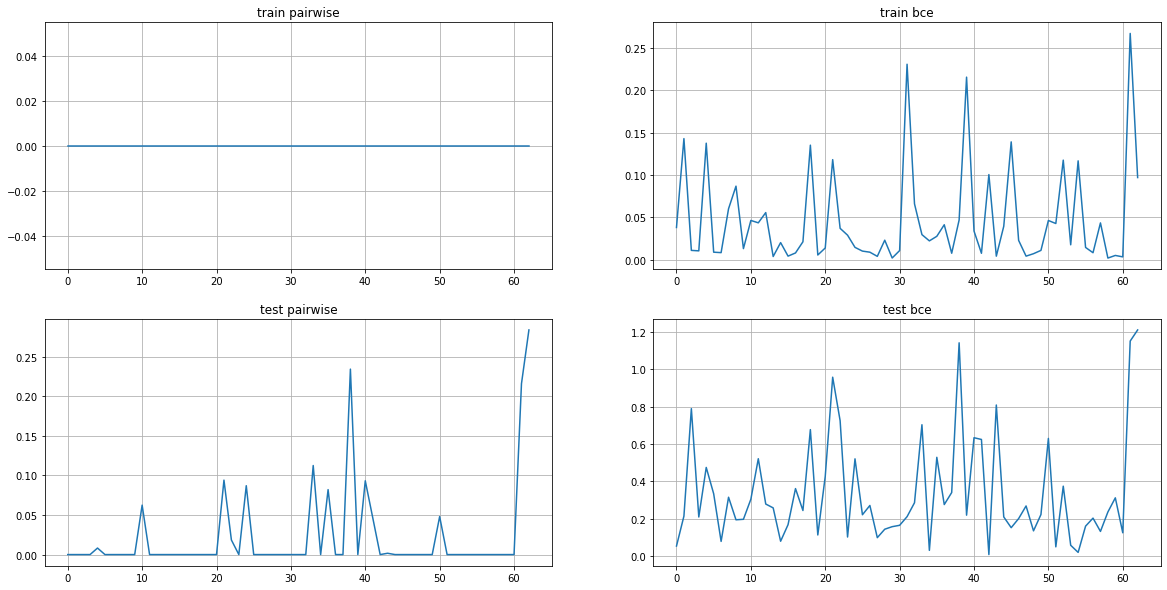

EPOCH 6


  0%|                                                                                                                                                                                       | 0/63 [00:00<?, ?it/s]/root/miniconda3/envs/pixemb/lib/python3.7/site-packages/torch/nn/functional.py:1909: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:54<00:00,  1.17it/s]


tensor([8.4538e-01, 9.9625e-01, 3.2233e-05, 1.8921e-04], device='cuda:0',
       grad_fn=<CatBackward0>) tensor([1., 1., 0., 0.], device='cuda:0')


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.05it/s]


tensor([6.9131e-01, 2.4339e-02, 2.3987e-04, 1.4426e-01], device='cuda:0') tensor([1., 1., 0., 0.], device='cuda:0')
rates:
137 241 9 113
accuracy, precision, recall:
0.756 0.9383561643835616 0.548
mean pairwise loss, train: 4.111774384029328e-06
mean bce loss, train: 0.04079252617093661
mean pairwise loss, test: 0.017940221838505258
mean bce loss, test: 0.7713505312327354


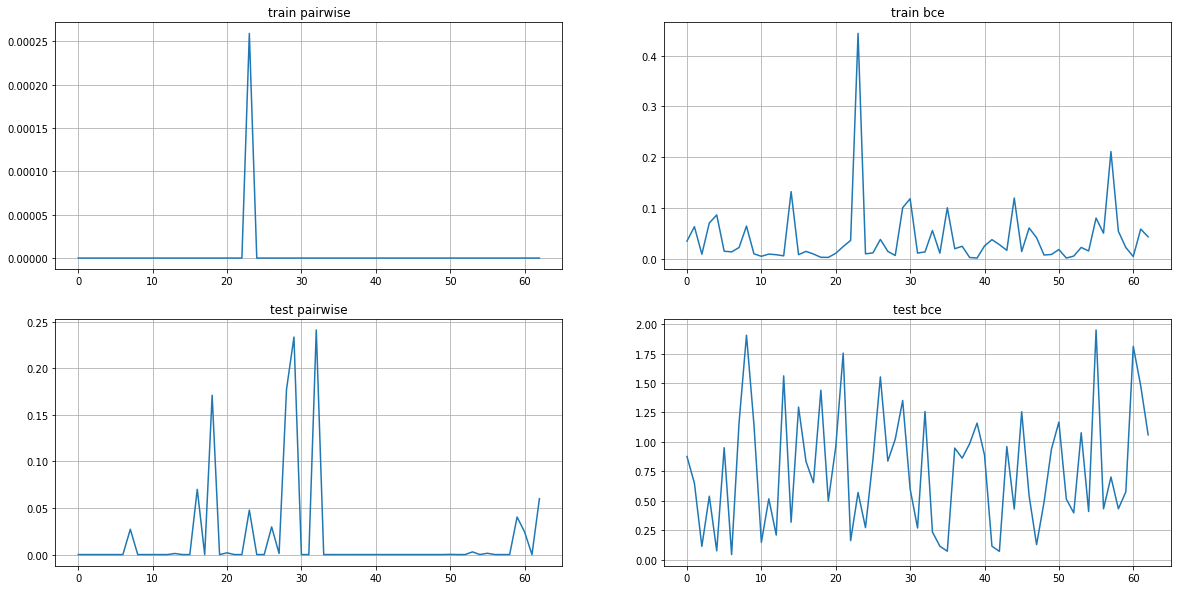

EPOCH 7


  0%|                                                                                                                                                                                       | 0/63 [00:00<?, ?it/s]/root/miniconda3/envs/pixemb/lib/python3.7/site-packages/torch/nn/functional.py:1909: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:53<00:00,  1.17it/s]


tensor([9.8248e-01, 9.8270e-01, 2.3555e-02, 8.5249e-04], device='cuda:0',
       grad_fn=<CatBackward0>) tensor([1., 1., 0., 0.], device='cuda:0')


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.04it/s]


tensor([0.0418, 0.1883, 0.0018, 0.0132], device='cuda:0') tensor([1., 1., 0., 0.], device='cuda:0')
rates:
141 240 10 109
accuracy, precision, recall:
0.762 0.9337748344370861 0.564
mean pairwise loss, train: 0.0
mean bce loss, train: 0.059800357730608315
mean pairwise loss, test: 0.011337720116393434
mean bce loss, test: 0.6478750114994389


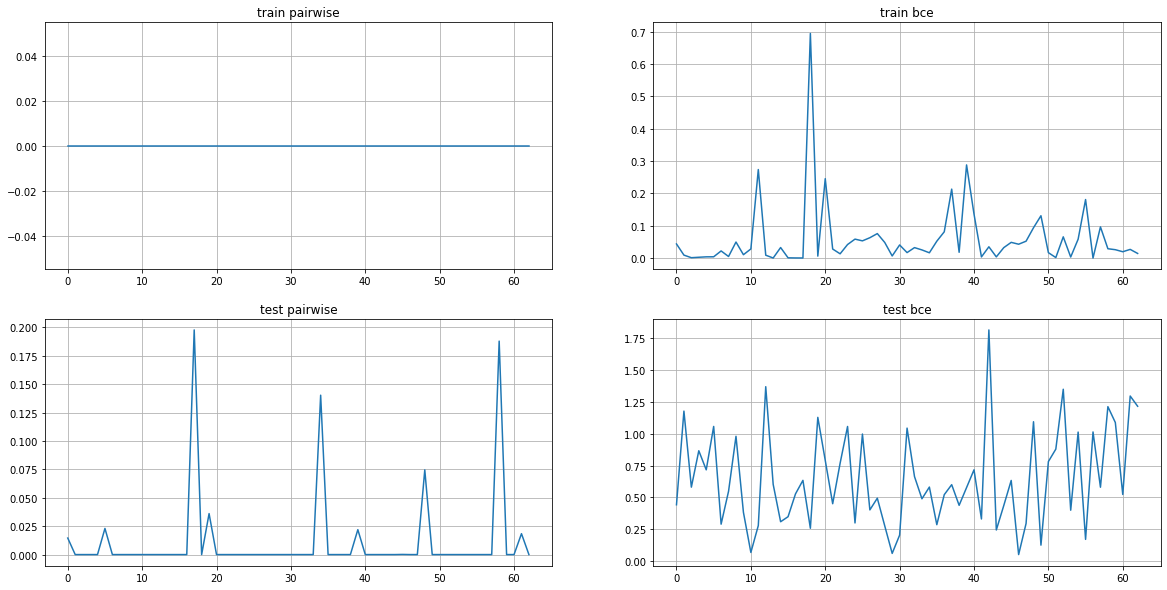

EPOCH 8


  0%|                                                                                                                                                                                       | 0/63 [00:00<?, ?it/s]/root/miniconda3/envs/pixemb/lib/python3.7/site-packages/torch/nn/functional.py:1909: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
 54%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 34/63 [00:29<00:24,  1.16it/s]

In [ ]:
n_epochs = 10
pairwise_losses = list()
bce_losses = list()
test_pairwise_losses = list()
test_bce_losses = list()

train_true_pos = 0
train_true_neg = 0
train_false_pos = 0
train_false_neg = 0

test_true_pos = 0
test_true_neg = 0
test_false_pos = 0
test_false_neg = 0

for epoch_num in range(n_epochs):
    print(f'EPOCH {epoch_num}')

    for i, batch in enumerate(tqdm.tqdm(train_dataloader)):
        optimizer.zero_grad()

        positive_images, negative_images, pos_labels, neg_labels = batch
        positive_images = positive_images.to(DEVICE)
        negative_images = negative_images.to(DEVICE)
        pos_labels = pos_labels.to(DEVICE)
        neg_labels = neg_labels.to(DEVICE)

        positive_outputs = model(positive_images).squeeze(1)
        negative_outputs = model(negative_images).squeeze(1)
        positive_probs = torch.sigmoid(positive_outputs)
        negative_probs = torch.sigmoid(negative_outputs)
        
        train_true_pos += (positive_probs > 0.5).sum().item()
        train_false_neg += (positive_probs < 0.5).sum().item()
        train_true_neg += (negative_probs < 0.5).sum().item()
        train_false_pos += (negative_probs > 0.5).sum().item()

        pairwise_loss = pairwise_criterion(positive_probs, negative_probs, pos_labels)
        pairwise_losses.append(pairwise_loss.item())

        all_probs = torch.cat([positive_probs, negative_probs])
        all_labels = torch.cat([pos_labels, neg_labels])

        bce_loss = bce_criterion(all_probs, all_labels)
        bce_losses.append(bce_loss.item())

        loss = 0.75 * pairwise_loss + 0.25 * bce_loss

        loss.backward()
        optimizer.step()
        
    print(all_probs, all_labels)
        
    with torch.no_grad():
        for i, batch in enumerate(tqdm.tqdm(test_dataloader)):
            positive_images, negative_images, pos_labels, neg_labels = batch
            positive_images = positive_images.to(DEVICE)
            negative_images = negative_images.to(DEVICE)
            pos_labels = pos_labels.to(DEVICE)
            neg_labels = neg_labels.to(DEVICE)

            positive_outputs = model(positive_images).squeeze(1)
            negative_outputs = model(negative_images).squeeze(1)
            positive_probs = torch.sigmoid(positive_outputs)
            negative_probs = torch.sigmoid(negative_outputs)
            
            test_true_pos += (positive_probs > 0.5).sum().item()
            test_false_neg += (positive_probs < 0.5).sum().item()
            test_true_neg += (negative_probs < 0.5).sum().item()
            test_false_pos += (negative_probs > 0.5).sum().item()

            test_pairwise_loss = pairwise_criterion(positive_probs, negative_probs, pos_labels)
            test_pairwise_losses.append(test_pairwise_loss.item())

            all_probs = torch.cat([positive_probs, negative_probs])
            all_labels = torch.cat([pos_labels, neg_labels])

            test_bce_loss = bce_criterion(all_probs, all_labels)
            test_bce_losses.append(test_bce_loss.item())

            loss = 0.75 * pairwise_loss + 0.25 * bce_loss
            
        print(all_probs, all_labels)

    accuracy = (test_true_pos + test_true_neg) / (test_true_pos + test_true_neg + test_false_pos + test_false_neg)
    precision = test_true_pos / (test_true_pos + test_false_pos)
    recall = test_true_pos / (test_true_pos + test_false_neg)
    print('rates:')
    print(test_true_pos, test_true_neg, test_false_pos, test_false_neg)
    print(f'test accuracy: {accuracy}')
    print(f'precision: {precision}')
    print(f'recall: {recall}')
    print(f'mean pairwise loss, test: {sum(test_pairwise_losses) / len(test_pairwise_losses)}')
    print(f'mean bce loss, test: {sum(test_bce_losses) / len(test_bce_losses)}')

    fig, axs = plt.subplots(2, 2, figsize=(20, 10))

    axs[0, 0].plot(np.arange(0, len(pairwise_losses)), pairwise_losses)
    axs[0, 0].set_title('train pairwise')
    axs[0, 0].grid()

    axs[0, 1].plot(np.arange(0, len(bce_losses)), bce_losses)
    axs[0, 1].set_title('train bce')
    axs[0, 1].grid()

    axs[1, 0].plot(np.arange(0, len(test_pairwise_losses)), test_pairwise_losses)
    axs[1, 0].set_title('test pairwise')
    axs[1, 0].grid()

    axs[1, 1].plot(np.arange(0, len(test_bce_losses)), test_bce_losses)
    axs[1, 1].set_title('test bce')
    axs[1, 1].grid()

    plt.show()

    pairwise_losses = list()
    bce_losses = list()
    test_pairwise_losses = list()
    test_bce_losses = list()
    test_true_pos = 0
    test_true_neg = 0
    test_false_pos = 0
    test_false_neg = 0